In [146]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import wandb
from pathlib import Path

np.random.seed(0)  # Seed for reproducibility


def generate_signal(fs=21000, T=0.01):
    """
    :param fs: Sampling frequency in Hz
    :param T: Length of signal in seconds
    :return: 
    """
    num_frequencies = np.random.randint(2, 5)  # Randomly choose how many frequencies to combine
    frequencies = np.random.randint(300, 2000, num_frequencies)
    phases = np.random.rand(num_frequencies) * 2 * np.pi

    # Time array
    t = np.linspace(0, T, int(T * fs), endpoint=False)

    # Generate a random continuous periodic signal
    signal = sum(np.sin(2 * np.pi * f * t + phase) for f, phase in zip(frequencies, phases))
    signal = signal / np.max(signal)

    # Add random noise to the signal
    noise = np.random.normal(0, 0.1, signal.shape)
    signal += noise
    signal = signal / np.max(signal)

    # Apply bandpass filter
    return t, signal


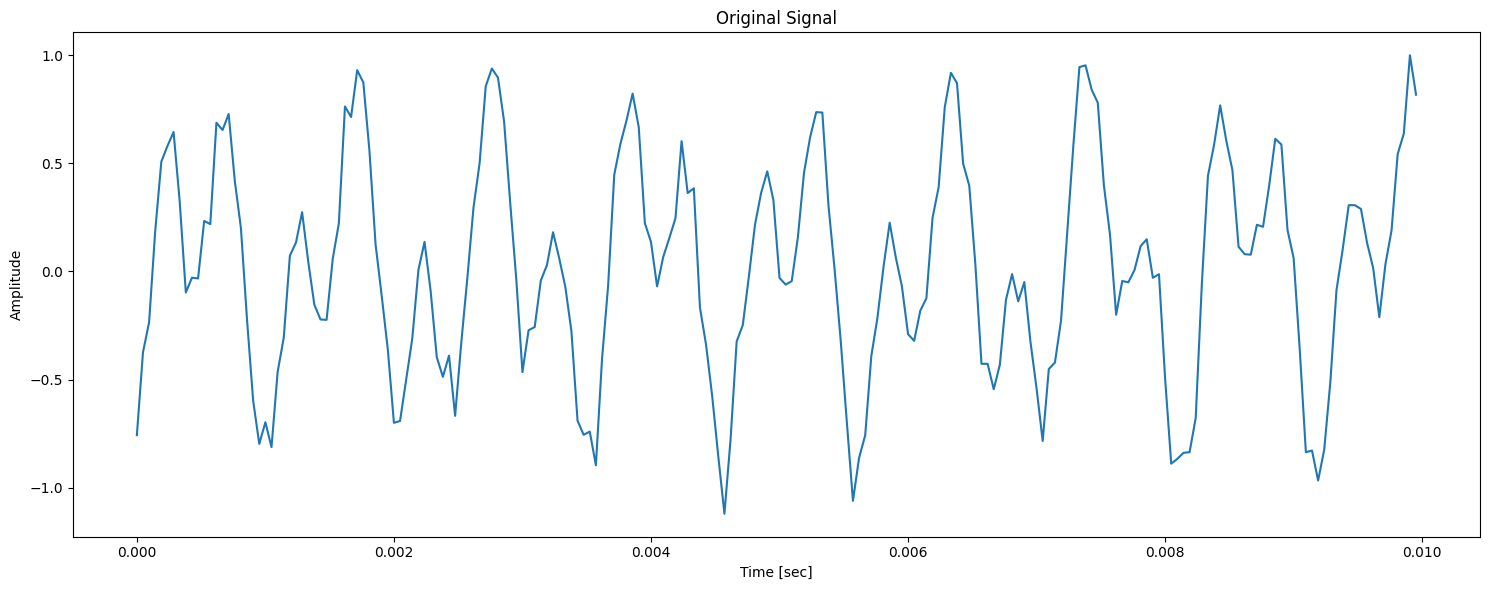

In [135]:
t, signal = generate_signal()
# Plotting
plt.figure(figsize=(15, 6))

plt.plot(t, signal)
plt.title('Original Signal')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()

In [136]:
class SignalDataset(Dataset):
    def __init__(self, size, fs=21000, T=0.005):
        """
        :param size: Number of samples in the dataset
        :param fs: Sampling frequency in Hz
        :param T: Length of each signal in seconds
        """
        self.size = size
        self.fs = fs
        self.T = T

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        _, signal = generate_signal(self.fs, self.T)
        # print("__getitem__")
        # Convert to PyTorch tensors
        signal = torch.tensor(signal, dtype=torch.float)
        target = torch.roll(signal, -1, dims=0)
        return signal.unsqueeze_(dim=-1), target.unsqueeze_(dim=-1)

In [141]:

class LSTMPredictor(torch.nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTMPredictor, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = torch.nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.linear_1 = torch.nn.Linear(hidden_layer_size, int(hidden_layer_size/2))
        self.linear_2 = torch.nn.Linear(int(hidden_layer_size/2), output_size)

    def forward(self, input_seq):
        x, _ = self.lstm(input_seq)
        x =  self.leaky_relu(x)
        x = self.linear_1(x)
        x = self.leaky_relu(x)
        x = self.linear_2(x)
        return x


In [148]:
# Nicer summary of model
def count_parameters(model):
    from prettytable import PrettyTable
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

model = LSTMPredictor()

checkpoint_path = './checkpoints/qpfhbse4/100_epochs_qpfhbse4'
# checkpoint_path = None
if checkpoint_path:
    checkpoint_data = checkpoint_path.split("/")[-1].split("_")
    start_epochs = int(checkpoint_data[0])
    wandb_id = checkpoint_data[-1]
    model.load_state_dict(torch.load(checkpoint_path))
else:
    start_epochs = 0
pram_count = count_parameters(model)

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| lstm.weight_ih_l0 |    400     |
| lstm.weight_hh_l0 |   40000    |
|  lstm.bias_ih_l0  |    400     |
|  lstm.bias_hh_l0  |    400     |
|  linear_1.weight  |    5000    |
|   linear_1.bias   |     50     |
|  linear_2.weight  |     50     |
|   linear_2.bias   |     1      |
+-------------------+------------+
Total Trainable Params: 46301


In [149]:
common_kwargs={
    'project':"time-series",
    'tags': [f"lr_{0.001}", f"params_{pram_count}"],
    'name':'harmonic-signal-prediction-lstm',
}
if checkpoint_path:
    wandb.init(
        **common_kwargs,
        id=wandb_id,
        resume=True
    )
else:
    wandb.init(
        **common_kwargs
    )

train loss,█▂▁▁▁▁
val loss,█▃▂▂▂▁
train loss,0.75448
val loss,0.75672


In [150]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
dataset = SignalDataset(size=1000)  # 600 signals
val_dataset = SignalDataset(size=1000)  # 100 signals
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
epochs = 900


for i in range(start_epochs, start_epochs + epochs + 1):
    model.train()
    train_loss = 0
    for seq, labels in dataloader:
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        train_loss += single_loss
        optimizer.step()

    if i % 20 == 0:
        model.eval()
        val_loss = 0
        for seq, labels in val_dataloader:
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            val_loss += single_loss
        print(f'TRAIN: epoch: {i},  loss: {train_loss.item()}')
        print(f'VAL: epoch: {i},  val loss: {val_loss.item()} \n')
        wandb.log({"train loss": train_loss.item(), "val loss": val_loss.item()}, i)
        Path(f"./checkpoints/{wandb.run.id}/").mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), f'./checkpoints/{wandb.run.id}/{i}_epochs_{wandb.run.id}')
        

TRAIN: epoch: 100,  loss: 0.8076617121696472
VAL: epoch: 100,  val loss: 0.7645535469055176 



wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 100 is less than current step: 101. Dropping entry: {'train loss': 0.8076617121696472, 'val loss': 0.7645535469055176, '_timestamp': 1711057840.26113}).


TRAIN: epoch: 120,  loss: 0.7320752143859863
VAL: epoch: 120,  val loss: 0.7232922911643982 

TRAIN: epoch: 140,  loss: 0.7478557825088501
VAL: epoch: 140,  val loss: 0.7693504691123962 

TRAIN: epoch: 160,  loss: 0.7129247188568115
VAL: epoch: 160,  val loss: 0.7416000366210938 

TRAIN: epoch: 180,  loss: 0.7468002438545227
VAL: epoch: 180,  val loss: 0.7208716869354248 

TRAIN: epoch: 200,  loss: 0.7305207848548889
VAL: epoch: 200,  val loss: 0.7145373821258545 

TRAIN: epoch: 220,  loss: 0.7086980938911438
VAL: epoch: 220,  val loss: 0.7374887466430664 

TRAIN: epoch: 240,  loss: 0.7265995144844055
VAL: epoch: 240,  val loss: 0.7294655442237854 

TRAIN: epoch: 260,  loss: 0.7091807723045349
VAL: epoch: 260,  val loss: 0.7116829752922058 

TRAIN: epoch: 280,  loss: 0.7050720453262329
VAL: epoch: 280,  val loss: 0.717392086982727 

TRAIN: epoch: 300,  loss: 0.7170892357826233
VAL: epoch: 300,  val loss: 0.7123523950576782 

TRAIN: epoch: 320,  loss: 0.709818959236145
VAL: epoch: 320, 

In [151]:
wandb.finish()

wandb: WARNING Ensure read and write access to run files dir: /Users/roncaglionidaniele/Documents/projects/time-series-prediciton/wandb/run-20240321_225017-qpfhbse4/files, control this via the WANDB_DIR env var. See https://docs.wandb.ai/guides/track/environment-variables


train loss,▇█▆█▇▅▇▆▆▆▅▅▅▅▄▅▅▅▅▄▅▄▅▄▄▄▃▅▃▃▃▄▃▂▃▁▃▃▁▃
val loss,▆█▇▅▅▆▆▅▅▄▅▅▄▄▄▃▄▄▄▄▄▄▃▄▄▄▄▄▃▃▃▄▃▂▄▂▃▃▁▁
train loss,0.67069
val loss,0.64044


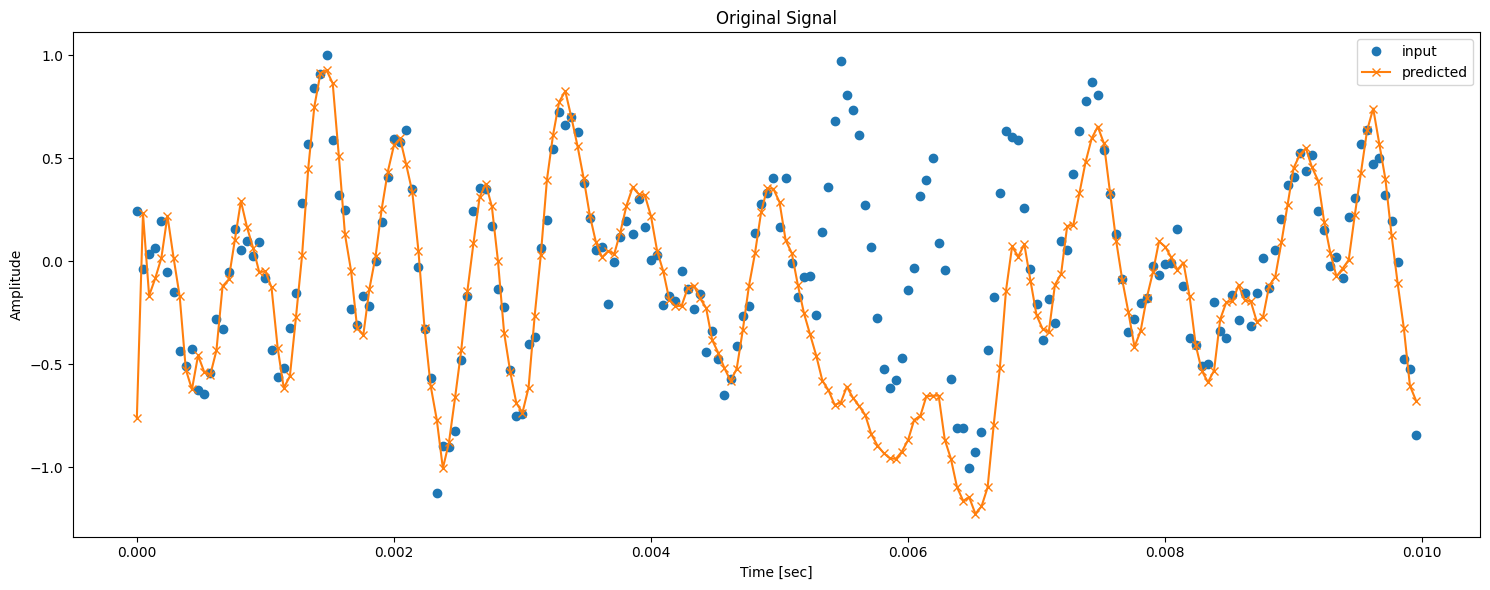

In [193]:
t, signal = generate_signal(T=0.01)
# N=100
# signal[N:]=np.random.uniform(size=len(signal)-N)
signal = torch.tensor(signal, dtype=torch.float)
# signal = torch.flip(signal,dims=(0,))
pred = model(signal.view(1, len(signal), 1))
predicted_signal = pred.view(len(signal)).detach()
predicted_signal = torch.roll(predicted_signal, 1, dims=0)

# Plotting
plt.figure(figsize=(15, 6))

plt.plot(t, signal, 'o', label='input')
plt.plot(t, predicted_signal, '-x', label='predicted')
plt.title('Original Signal')
plt.legend(loc='best')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()

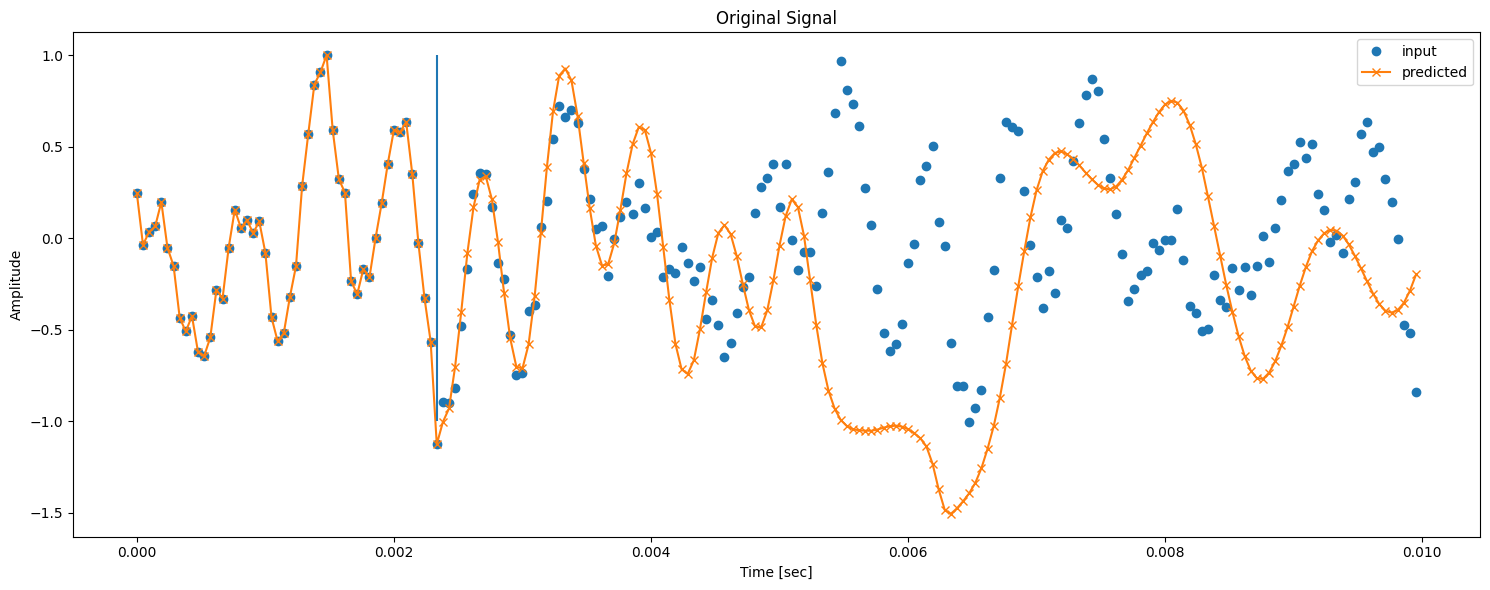

In [194]:

# N=100
# signal[N:]=np.random.uniform(size=len(signal)-N)
signal_continuation_autoreg = torch.clone(signal)
signal_continuation_autoreg[50:] = 0
for i in range(len(signal[50:])):
    pred = model(signal_continuation_autoreg.view(1, len(signal_continuation_autoreg), 1))
    pred = pred.view(len(signal_continuation_autoreg)).detach()
    signal_continuation_autoreg[50+i] = pred[50+i-1]

# Plotting
plt.figure(figsize=(15, 6))

plt.plot(t, signal, 'o', label='input')
plt.plot(t, signal_continuation_autoreg, '-x', label='predicted')
plt.title('Original Signal')
plt.legend(loc='best')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')

plt.vlines(t[49], -1,1)

plt.tight_layout()
plt.show()